# Домашнее задание 6

**Обучить сиамскую сеть для верификации лиц на датасете LFW**
**Библиотеки: [Python, Tensorflow]**

Данные, необходимые для этого модуля:
* al_gore1.jpg
* al_gore2.jpg
* pamela_anderson.jpg

## Переключение версии TensorFlow

In [1]:
%tensorflow_version 2.x

## Подключение библиотек

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf
import tensorflow_datasets as tfds

## Проверить версию библиотек

In [3]:
tf.__version__

'2.3.0'

## Загрузка и подготовка датасета LFW

In [4]:
(train_ds, test_ds), lfw_ds_info = tfds.load(
    'lfw',
    as_supervised=True,
    with_info=True,
    split=['train[:90%]', 'train[90%:]']
)

Shuffling and writing examples to /root/tensorflow_datasets/lfw/0.1.0.incompleteAKVZRR/lfw-train.tfrecord



Dataset lfw downloaded and prepared to /root/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.


In [5]:
lfw_ds_info

tfds.core.DatasetInfo(
    name='lfw',
    version=0.1.0,
    description='Labeled Faces in the Wild:
        A Database for Studying Face Recognition in
        Unconstrained Environments',
    homepage='http://vis-www.cs.umass.edu/lfw',
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=13233,
    splits={
        'train': 13233,
    },
    supervised_keys=('label', 'image'),
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
        year = 2007,
        number = {07-49},
        month = {October}
    }""",
    redistribution_info=,
)

In [6]:
train_ds

<DatasetV1Adapter shapes: ((), (250, 250, 3)), types: (tf.string, tf.uint8)>

In [7]:
test_ds

<DatasetV1Adapter shapes: ((), (250, 250, 3)), types: (tf.string, tf.uint8)>

## Визуализация датасета LFW

In [8]:
samples = [[x[0], x[1]] for x in iter(train_ds.take(25))]

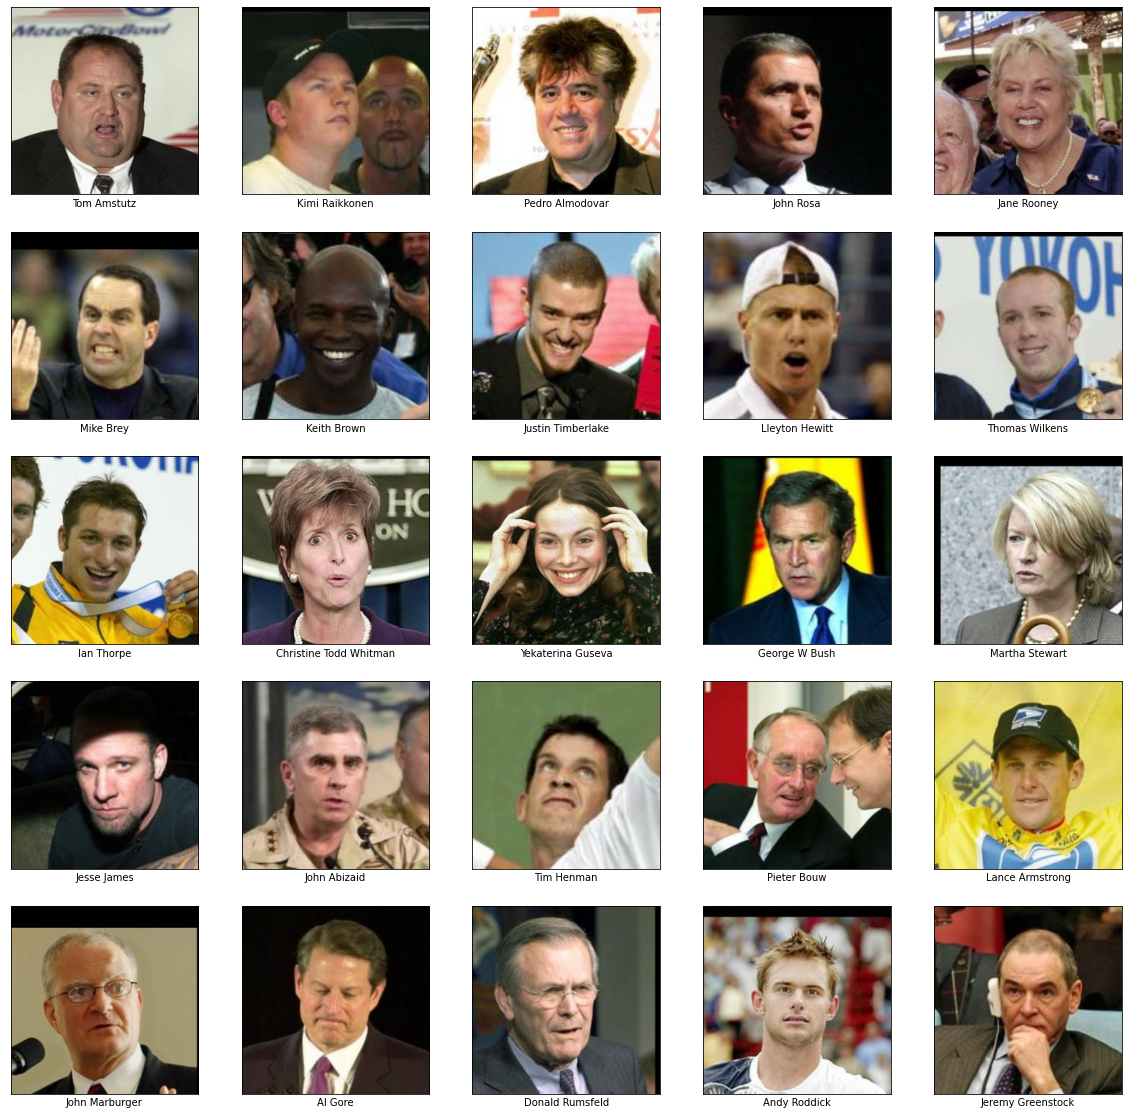

In [9]:
plt.figure(figsize=(20,20))
for i in range(len(samples)):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(samples[i][1])
    plt.xlabel(samples[i][0].numpy().decode().replace("_", " "))
plt.show()

## Создание модели CNN

In [10]:
EMB_SIZE = 64

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

## Contrastive Loss

In [11]:
MARGIN = 10.0

def contrastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d = tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

## Подготовка пайплайна данных

In [12]:
def norm_sample(label, image):
    return label, tf.cast(image, tf.float32) / 255.

In [13]:
NUM_EPOCHS = 5
BATCH_SIZE = 64

train_ds = train_ds.map(norm_sample)
train_ds = train_ds.shuffle(buffer_size=int(lfw_ds_info.splits['train'].num_examples*0.5))
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

## Подготовка к обучению

In [14]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

## Обучение модели

In [15]:
%%time

for iteration, (labels, images) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contrastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 50 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 92.47859191894531
[50] Loss: 0.0
[100] Loss: 0.0
[150] Loss: 0.0
[200] Loss: 0.0
[250] Loss: 0.0018537209834903479
[300] Loss: 0.31256768107414246
[350] Loss: 0.0
[400] Loss: 0.0
[450] Loss: 0.0
[500] Loss: 0.0
[550] Loss: 0.7870672941207886
[600] Loss: 0.17629538476467133
[650] Loss: 0.0
[700] Loss: 7.279653072357178
[750] Loss: 0.030819566920399666
[800] Loss: 13.61897087097168
[850] Loss: 0.0
[900] Loss: 0.0
CPU times: user 4min 5s, sys: 2min 11s, total: 6min 16s
Wall time: 7min 44s


## Тестирование на новых данных

In [16]:
def draw_embeddings(X_embedded, targets, labels):
    plt.figure(figsize=(10, 10))
    for class_idx in range(np.max(targets)+1):
        X_embedded_class = X_embedded[targets == class_idx, :]
        plt.scatter(X_embedded_class[:,0], X_embedded_class[:,1])
    plt.legend(labels, loc='best')
    plt.grid(True)

In [17]:
def load_and_prepare_image(fpath):
    import imageio
    from skimage.transform import resize
    img = imageio.imread(fpath, pilmode="RGB")
    img = img.astype(np.float32) / 255.
    img = resize(img, (280, 280, 3), mode='reflect', anti_aliasing=True)
    img = np.reshape(img, (280, 280, 3))
    return img

In [18]:
img_a1 = load_and_prepare_image('al_gore1.jpg') 
img_a2 = load_and_prepare_image('al_gore2.jpg') 
img_b1 = load_and_prepare_image('pamela_anderson.jpg')

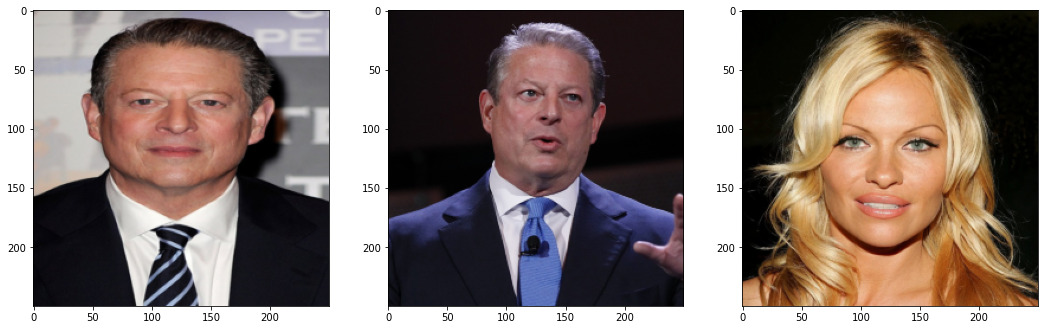

In [19]:
fig = plt.figure(figsize=[18,9])
ax = fig.add_subplot(1, 3, 1)
ax.imshow(img_a1)
ax = fig.add_subplot(1, 3, 2)
ax.imshow(img_a2)
ax = fig.add_subplot(1, 3, 3)
ax.imshow(img_b1)
plt.show()

In [20]:
new_embs = model(np.stack((img_a1, img_a2, img_b1), axis=0))

In [22]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb1 = new_embs[0,:]
emb2 = new_embs[1,:]
emb3 = new_embs[2,:]

print('al_gore1 <-> al_gore2: ', diff(emb1, emb2))
print('al_gore2 <-> pamela_anderson: ', diff(emb2, emb3))
print('al_gore1 <-> pamela_anderson: ', diff(emb1, emb3))

al_gore1 <-> al_gore2:  115.40611460863978
al_gore2 <-> pamela_anderson:  117.58748405442647
al_gore1 <-> pamela_anderson:  83.09256298512821


**Выводы:** результат получился не совсем тот, который я ожидал. Значение 'al_gore1 <-> al_gore2' ожидалось небольшим, а два других сравнения должны были бы иметь высокие значения. Почему получилось так, как получилось - затрудняюсь сказать. Возможно, требуется пересмотреть архитектуру сети.